<a href="https://colab.research.google.com/github/Mohamed-Ibrahim-01/heart-sound-classificatoin/blob/master/heart_sound_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q PyDrive2

     |████████████████████████████████| 55 kB 2.7 MB/s 
     |████████████████████████████████| 4.0 MB 15.6 MB/s 


In [2]:
import numpy as np
import pandas as pd
import librosa.display
import zipfile
import matplotlib.pyplot as plt
import shutil
import glob
import os
import re
from pathlib import Path

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
MAX_DURATION = 2000
BASE_DIR = os.getcwd()

PascalInfo = {
    "NAME" : "pascal",
    "ZIP_NAME" : "Pascal.zip",
    "DRIVE_ID" : "1nkSqb_B-uqv7-zka9HlmAcLkoDET2mqk",
    "ZIP_PATH" : ""
}

Dirs = {
    "BASE" : BASE_DIR,
    "DATASETS" : f"{BASE_DIR}{os.sep}datasets",
}


In [5]:
def download_from_drive(file_id, file_name):
    curr_dir = os.getcwd()
    drive_file = drive.CreateFile({'id': file_id})
    drive_file.GetContentFile(file_name)
    downloaded_path = f"{curr_dir}{os.sep}{file_name}"
    return downloaded_path

PascalInfo["ZIP_PATH"] = download_from_drive(PascalInfo["DRIVE_ID"], PascalInfo["ZIP_NAME"])

In [6]:
def load_dataset(dataset_info):
    name, zip_path = dataset_info['NAME'], dataset_info["ZIP_PATH"]
    dataset_dir = f"{Dirs['DATASETS']}{os.sep}{name}"
    if(os.path.exists(dataset_dir)):
        shutil.rmtree(dataset_dir)
    Path(dataset_dir).mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    return dataset_dir

def folder_label(folder_path):
    label = re.findall(r"murmur|normal|extrastole", folder_path.lower())
    if len(label) == 0:
        return "other"
    return label[0] if label[0] != "extrastole" else "extrasystole"

def load_pascal():
    pascal_dir = load_dataset(PascalInfo)
    zip_files = glob.glob(f'{pascal_dir}{os.sep}*.zip')
    for zip_path in zip_files:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(pascal_dir)
    folders = glob.glob(f'{pascal_dir}{os.sep}*{os.sep}')
    folders.pop()
    sounds = []
    for folder_path in folders:
        label = folder_label(folder_path)
        if label not in {"murmur", "normal", "extrasystole"}:
            continue
        wav_files = glob.glob(f'{folder_path}{os.sep}*.wav')
        for sound_path in wav_files:
            sound_name = os.path.basename(sound_path).split(".")[0]
            sounds.append([sound_name, sound_path, label])
    return pd.DataFrame(sounds, columns=["name", "path", "label"])

pascal_df = load_pascal()
pascal_df.head()


,name,path,label
0,290_1311182875320_A,/content/datasets/pascal/Training B Normal/290...,normal
1,103_1305031931979_D1,/content/datasets/pascal/Training B Normal/103...,normal
2,204_1308159229275_C,/content/datasets/pascal/Training B Normal/204...,normal
3,273_1309370841191_B,/content/datasets/pascal/Training B Normal/273...,normal
4,155_1306935902813_B1,/content/datasets/pascal/Training B Normal/155...,normal


In [7]:
dataset_df = pascal_df
normal_df = dataset_df[dataset_df["label"] == "normal"]
murmur_df = dataset_df[dataset_df["label"] == "murmur"]
extrasystole_df = dataset_df[dataset_df["label"] == "extrasystole"]

print("Dataset B: ", dataset_df.shape, list(dataset_df.columns))
print("Normal: ", normal_df.shape, "Murmur: ", murmur_df.shape,  "Extrasystole: ", extrasystole_df.shape)

Dataset B:  (266, 3) ['name', 'path', 'label']
Normal:  (200, 3) Murmur:  (66, 3) Extrasystole:  (0, 3)


In [10]:
random_normal_sample = normal_df.iloc[1]["path"]

assert(os.path.exists(random_normal_sample))

In [37]:
def plot_hs(path, dur=1.5, verts=[], sr=4000):
    y, sr = librosa.load(path, sr=sr, duration=dur)
    fig, ax = plt.subplots(nrows=1, figsize=(20,4))
    for line in verts:
        ax.axvline(x=line, color="red", ls='--')
    librosa.display.waveshow(y, sr=sr, ax=ax)
    ax.set(title=f'{path.split("/")[-1]}')
    plt.show()
    return (y, sr)

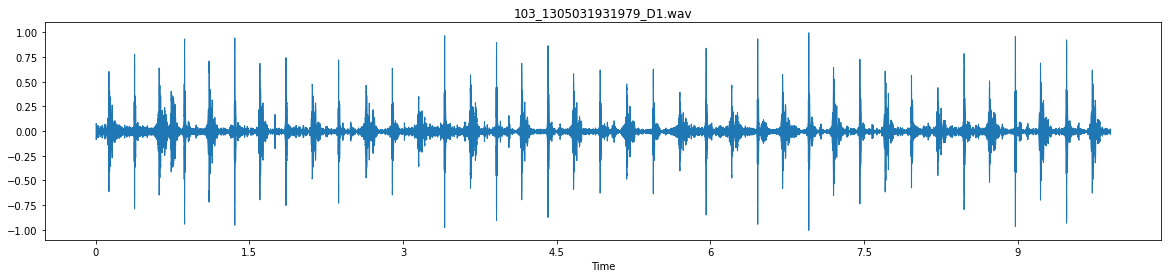

In [12]:
from IPython.display import Audio
y, sr = plot_hs(random_normal_sample, dur=MAX_DURATION)
Audio(data=y, rate=sr)

In [14]:
segments_df = pd.read_csv("/content/datasets/pascal/Btraining_normal_seg.csv")
segments_df.rename(columns={'Unnamed: 0':'name'}, inplace=True)
segments_df['name'] = segments_df['name'].str.replace('.aiff$', '', regex=True)
display(segments_df.head(5))
display(segments_df.shape)

,name,S1,S2,S1.1,S2.1,S1.2,S2.2,S1.3,S2.3,S1.4,...,S1.25,S2.25,S1.26,S2.26,S1.27,S2.27,S1.28,S2.28,S1.29,S2.29
0,103_1305031931979_D1,430.0,1547,2406,3437,4468.0,5413.0,6358.0,7389.0,8420.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,103_1305031931979_D3,481.0,1524,2486,3448,4491.0,5533.0,6576.0,7619.0,8581.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,106_1306776721273_C1,831.0,2076,3987,5288,7835.0,9192.0,11102.0,12375.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,106_1306776721273_D1,393.0,1682,3256,4545,6096.0,7364.0,9921.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,109_1305653646620_C,861.0,2186,4172,5497,7881.0,9206.0,11259.0,12583.0,14305.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(90, 61)

In [15]:
pascal_segmented_df = pascal_df.join(segments_df.set_index('name'), on='name', how='inner')


In [16]:
print(segments_df.iloc[0].dropna())

name     103_1305031931979_D1
S1                      430.0
S2                       1547
S1.1                     2406
S2.1                     3437
S1.2                   4468.0
S2.2                   5413.0
S1.3                   6358.0
S2.3                   7389.0
S1.4                   8420.0
S2.4                   9451.0
S1.5                  10482.0
S2.5                  11514.0
S1.6                  12545.0
S2.6                  13576.0
S1.7                  14607.0
S2.7                  15552.0
S1.8                  16583.0
S2.8                  17614.0
S1.9                  18559.0
S2.9                  19590.0
S1.10                 20707.0
S2.10                 21738.0
S1.11                 22769.0
S2.11                 23800.0
S1.12                 24746.0
S2.12                 25777.0
S1.13                 26722.0
S2.13                 27753.0
S1.14                 28784.0
S2.14                 29815.0
S1.15                 30760.0
S2.15                 31791.0
S1.16     

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:5258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


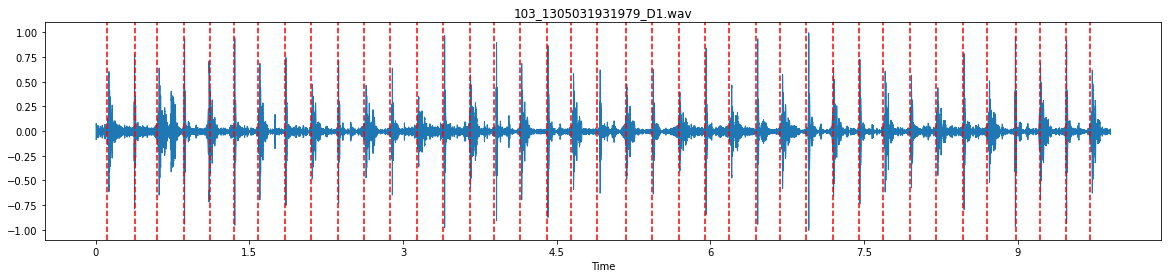

39610 4000
normal


In [17]:
seg_sound = pascal_segmented_df.iloc[0]
seg_sound.dropna(inplace=True,)
seg_positions = seg_sound.values[3:]/4000
y, sr = plot_hs(seg_sound["path"], verts=seg_positions, dur=50)
print(len(y), sr)
print(seg_sound["label"])

In [18]:
Audio(data=y, rate=sr)

In [24]:
np.zeros(30).tolist()
print( seg_sound.tolist())

['103_1305031931979_D1', '/content/datasets/pascal/Training B Normal/103_1305031931979_D1.wav', 'normal', 430.0, 1547, 2406, 3437, 4468.0, 5413.0, 6358.0, 7389.0, 8420.0, 9451.0, 10482.0, 11514.0, 12545.0, 13576.0, 14607.0, 15552.0, 16583.0, 17614.0, 18559.0, 19590.0, 20707.0, 21738.0, 22769.0, 23800.0, 24746.0, 25777.0, 26722.0, 27753.0, 28784.0, 29815.0, 30760.0, 31791.0, 32822.0, 33853.0, 34798.0, 35915.0, 36860.0, 37892.0, 38837.0]


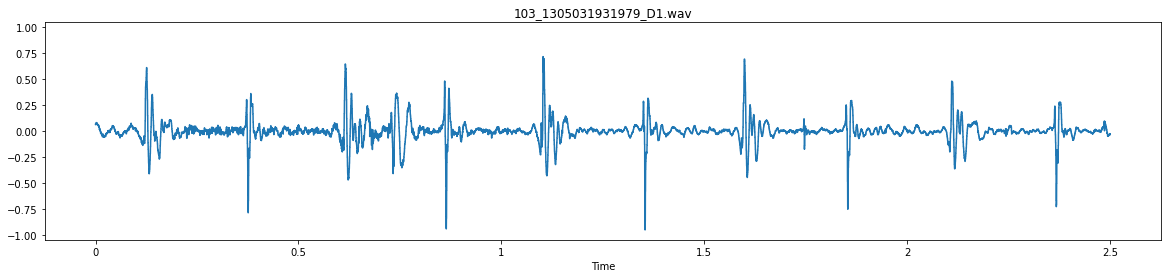

0.10218815684574922


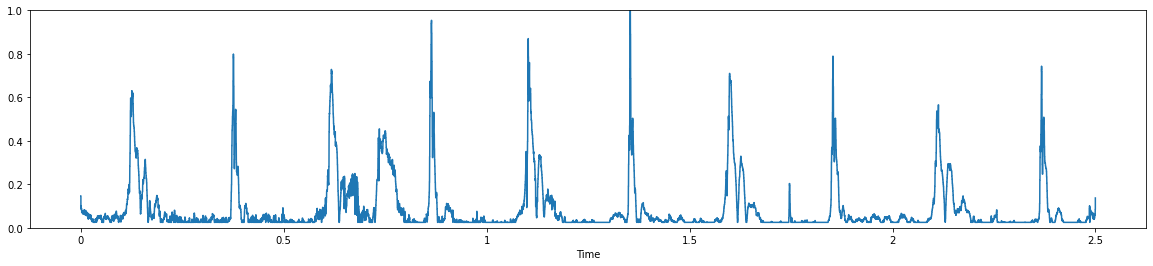

In [115]:
from scipy import ndimage

def normalize(signal):
    base = min(signal)
    range = max(signal) - base
    normalized = [(x-base)/range for x in signal]
    return np.array(normalized)

sound, sr = plot_hs(seg_sound["path"], dur=2.5)
#sound = normalize(sound)

analytic_signal = hilbert(sound)
amplitude_envelope = np.abs(analytic_signal)

#envelope = ndimage.grey_closing(sound, structure=np.zeros(30))
envelope = normalize(amplitude_envelope)

def threshold_envelope(envelope, lmda, ref_threshold):
    std = np.std(envelope, dtype=np.float64)
    threshold = min(ref_threshold, lmda*std)
    print(lmda*std)
    return np.clip(envelope, threshold, 1)

envelope = threshold_envelope(envelope, 0.8, 0.025)

#envelope = ndimage.grey_opening(envelope, structure=np.zeros(50))
#envelope = normalize(envelope)

fig, ax = plt.subplots(nrows=1, figsize=(20,4))
ax.set(ylim=[0, 1])
librosa.display.waveshow(envelope, sr=sr, ax=ax)



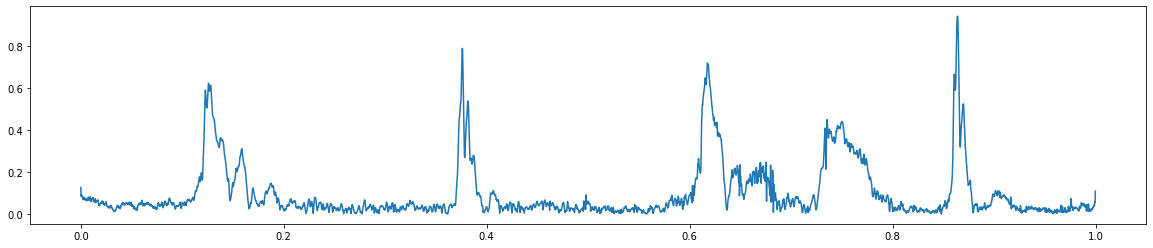

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp


#signal = chirp(t, 20.0, t[-1], 100.0)
#signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t))

signal = sound
samples = len(signal)
t = np.arange(samples) / 4000

analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)

fig, ax = plt.subplots(nrows=1, figsize=(20,4))

#ax.plot(t, signal, label='signal')
ax.plot(t, amplitude_envelope, label='envelope')
plt.show()

In [93]:
from skimage.restoration import estimate_sigma, denoise_wavelet
def denoising(signal):
  sigma_hat = estimate_sigma(signal, average_sigmas=False)
  denoised_signal = denoise_wavelet(signal, sigma=sigma_hat, wavelet='db4', mode='soft', multichannel=False, method='BayesShrink', rescale_sigma=True)
  return denoised_signal

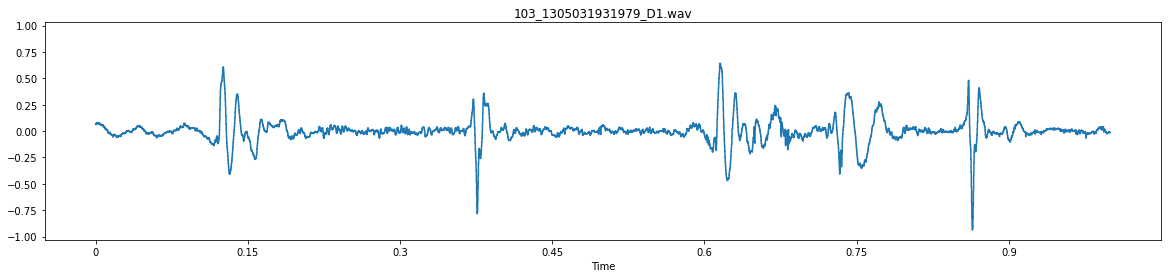

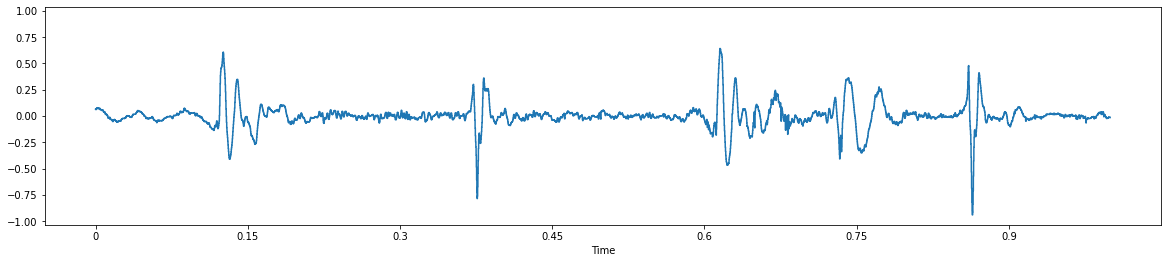

In [108]:
sound, sr = plot_hs(seg_sound["path"], dur=1)
dn_sound = denoising(sound)
fig, ax = plt.subplots(nrows=1, figsize=(20,4))
librosa.display.waveshow(dn_sound, sr=sr, ax=ax)

In [106]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)
print(signaltonoise(sound))
print(signaltonoise(dn_sound))

-0.003030102699995041
-0.00303056207485497
